<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2020 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import os

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import seaborn as sns
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn import decomposition
from sklearn.metrics.cluster import contingency_matrix
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

init_notebook_mode(connected=True)

In [3]:
def save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/temporal/' ):
    for i in range(len(skills_ratings)):
        for j in range(i + 1, len(skills_ratings)):
            #Eligo dos números entre 0 y  de n_skills-1
            skill_1 = skills_ratings[i]
            skill_2 = skills_ratings[j]

            kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                                        mode='markers',
                                        text=df_n.loc[:,'team_position'], # 'height', 'weight', 'club', 'age', 'short_name', 'position'
                                        marker=dict(
                                            size=5,
                                            color = clusters.astype(np.float), #set color equal to a variable
                                            colorscale='Portland',
                                            showscale=False)
                                       )

            crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                                  text=df_n.loc[bool_crack,'short_name'],
                                  textfont=dict(family='sans serif',size=10,color='black'),
                                  opacity=0.9,mode='text')

            data=[kmean_clusters,crack]

            layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                            xaxis=dict(title=skill_1),
                            yaxis=dict(title=skill_2),
                            autosize=False, width=1000,height=1000)

            fig = go.Figure(data=data, layout=layout)

            file_path = folder_path + '{}_vs_{}.png'.format(skill_1, skill_2)
            if not os.path.exists(file_path):
                #iplot(fig)
                fig.write_image(file_path)
                

def player_positions_series_from_group( df, group_label, col_position = 'player_positions' ):
    array=[]
    group = df[df.group_label == group_label]
    for x in group[col_position]:
        array.extend(x.split(', '))    
    return pd.Series(array)

def get_colum_series_by_group(df, column_name, group_label):
    return df[df.group_label == group_label][column_name]

def print_Silohuette(n_clusters, cluster_labels, df_skills, title):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (n_clusters + 1) * 10])

    #cluster_labels = km.labels_

    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((title),
                 fontsize=14, fontweight='bold')

    plt.show()

    
def print_kmeans_inertia(df_skills, cluster_range=10):
    scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(cluster_range)]

    plt.plot(np.arange(2, 12), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")
    plt.show()

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("players_20.csv")
df.describe()
null_columns = df.columns[df.isnull().any()]
null_columns

Index(['release_clause_eur', 'player_tags', 'team_position',
       'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until',
       'nation_position', 'nation_jersey_number', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object')

In [5]:
df.isna().sum()

sofifa_id                         0
player_url                        0
short_name                        0
long_name                         0
age                               0
dob                               0
height_cm                         0
weight_kg                         0
nationality                       0
club                              0
overall                           0
potential                         0
value_eur                         0
wage_eur                          0
player_positions                  0
preferred_foot                    0
international_reputation          0
weak_foot                         0
skill_moves                       0
work_rate                         0
body_type                         0
real_face                         0
release_clause_eur             1298
player_tags                   16779
team_position                   240
team_jersey_number              240
loaned_from                   17230
joined                      

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [6]:
n = 10000  # cantidad de jugadores a considerar

df_n = df.loc[:n]  # se reduce la base a los n primeros jugadores

df_n = df_n[(df_n.overall > 70)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]
df_skills.isna().sum()
df_skills = df_skills.fillna(0)

40 variables numéricas de desempeño según habilidad


In [7]:
df[df.passing.isna()].player_positions.value_counts()

GK    2036
Name: player_positions, dtype: int64

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [8]:
# Número de clusters buscado
n_cluster_kmean = 4

km = KMeans(n_clusters=n_cluster_kmean, random_state=10)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

clusterer = KMeans(n_clusters=n_cluster_kmean, random_state=10)
cluster_labels = clusterer.fit_predict(df_skills)
clusters

Suma de los cuadrados de las distancias al cluster / Inertia:  12248167.979694195


array([0, 0, 0, ..., 2, 2, 3], dtype=int32)

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

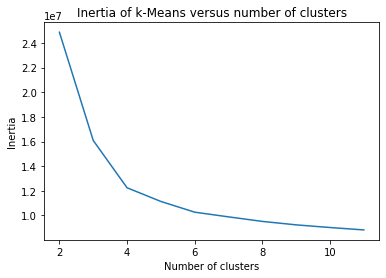

In [9]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
print_kmeans_inertia(df_skills)

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [10]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                            mode='markers',
                            text=df_n.loc[:,'team_position'],
                            marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'team_position'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means - K = {} ".format(n_cluster_kmean),titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [11]:
df_cluster_kmean=df_n.copy()
df_cluster_kmean['group_label'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette? https://es.qwe.wiki/wiki/Silhouette_(clustering)


### Cantidad de observaciones por Cluster

In [12]:
df_cluster_count = df_cluster_kmean.groupby(by=['group_label']).count()[['sofifa_id']]
df_cluster_count.columns = ['observaciones']
df_cluster_count

,observaciones
group_label,
0,1659
1,440
2,1734
3,923


### Análisis descriptivo separado por clase
#### Grupo 0

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,0.0,0.0,0.0,0.0,0.0,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000
mean,64.663653,72.145871,61.175407,66.923448,70.718505,66.901145,74.994575,75.212176,67.184448,60.168174,75.259795,75.946353,75.537071,76.053647,71.787824,71.792043,74.207957,66.796263,69.975286,66.285714,69.021097,57.667269,34.829415,73.797468,68.594334,67.097649,71.312236,36.731766,33.984931,29.971670,NaN,NaN,NaN,NaN,NaN,10.567812,10.638336,10.650995,10.515973,10.498493
std,11.261191,6.286807,13.723619,7.534772,5.912895,8.674442,5.498270,6.028447,10.775468,13.775515,5.122682,10.751279,10.186277,10.313255,5.941477,12.306678,6.488798,12.937941,8.834014,13.396536,7.220475,13.744926,11.253273,5.871870,8.164990,8.532284,6.782786,11.798050,11.206275,10.420868,NaN,NaN,NaN,NaN,NaN,3.135185,3.103852,3.149945,3.151801,3.213432
min,25.000000,44.000000,20.000000,41.000000,52.000000,32.000000,55.000000,53.000000,26.000000,22.000000,57.000000,28.000000,30.000000,32.000000,54.000000,29.000000,39.000000,29.000000,30.000000,27.000000,40.000000,22.000000,10.000000,53.000000,38.000000,31.000000,47.000000,10.000000,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
25%,59.000000,68.000000,50.000000,62.000000,67.000000,62.000000,72.000000,71.000000,61.000000,50.500000,72.000000,70.000000,70.000000,71.000000,68.000000,66.000000,70.000000,60.000000,65.500000,58.000000,65.000000,48.000000,26.000000,70.000000,64.000000,62.000000,67.000000,28.000000,25.000000,22.000000,NaN,NaN,NaN,NaN,NaN,8.000000,8.000000,8.000000,8.000000,8.000000
50%,67.000000,72.000000,62.000000,68.000000,71.000000,68.000000,75.000000,75.000000,68.000000,62.000000,75.000000,77.000000,76.000000,77.000000,71.000000,73.000000,75.000000,68.000000,71.000000,67.000000,69.000000,58.000000,34.000000,73.000000,69.000000,68.000000,71.000000,36.000000,33.000000,29.000000,NaN,NaN,NaN,NaN,NaN,11.000000,11.000000,11.000000,10.000000,10.000000
75%,72.000000,76.000000,73.000000,72.000000,75.000000,73.000000,78.000000,79.000000,75.000000,71.000000,78.000000,83.000000,83.000000,83.000000,75.000000,80.000000,78.000000,75.000000,76.000000,76.000000,73.500000,68.000000,43.000000,77.000000,74.000000,73.000000,76.000000,45.000000,42.000000,37.000000,NaN,NaN,NaN,NaN,NaN,13.000000,13.000000,13.000000,13.000000,13.000000
max,91.000000,95.000000,93.000000,92.000000,92.000000,90.000000,96.000000,97.000000,94.000000,94.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,93.000000,95.000000,94.000000,93.000000,69.000000,95.000000,94.000000,92.000000,96.000000,73.000000,66.000000,62.000000,NaN,NaN,NaN,NaN,NaN,27.000000,25.000000,31.000000,33.000000,37.000000


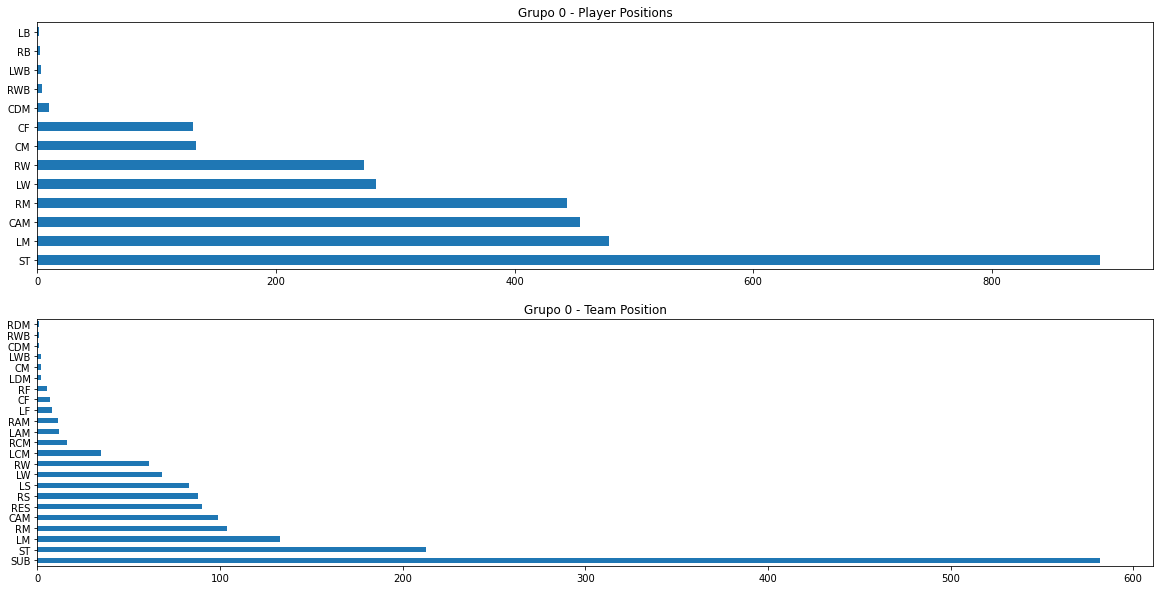

In [13]:
(fig, axs) = plt.subplots(2, 1, figsize=(25, 20), sharey=False)
player_positions_series_from_group(df_cluster_kmean,
                                   group_label=0).value_counts().plot(kind='barh', figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 0 - Player Positions')

column = 'team_position'

get_colum_series_by_group(df_cluster_kmean, column,
                          group_label=0).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 0 - Team Position')

df_km_group_0 = df_cluster_kmean[df_cluster_kmean.group_label == 0]
df_km_group_0[skills_ratings].describe()

#### Conclusión Grupo 0:
Este grupo claramente esta conformado mayormente por judares que juegan en la posición de delanteros, se observa valores altos en skills de ataque, valores bajos para las habilidades de defensa y habilidades nulas como arqueros. 
Tambien se observa que los jugadores tambien pueden jugar en el medio campo. La habilidades entre medio cambpo y delantero suelen ser muy parecidas. Razón por la cual entendemos ambas posiciones esten en el grupo.


### Grupo 1

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,440.000000,440.000000,440.000000,0.0,440.000000,440.000000,0.0,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,14.945455,13.175000,14.909091,NaN,30.352273,13.706818,NaN,15.400000,15.740909,15.034091,22.768182,44.488636,44.452273,46.302273,71.136364,44.947727,52.845455,64.925000,33.927273,65.977273,13.956818,29.429545,19.715909,12.756818,46.470455,22.175000,53.890909,16.902273,14.579545,14.352273,75.765909,72.715909,70.279545,74.331818,77.222727,75.765909,72.715909,70.279545,74.331818,77.222727
std,4.477402,3.302351,4.320941,NaN,8.677780,3.371183,NaN,4.273028,5.188138,5.052907,6.481154,9.170611,8.970846,11.994570,5.449670,10.336458,4.827666,9.998237,6.619099,9.627903,3.294981,7.893052,4.950665,3.500400,12.653937,7.252605,11.487416,4.845870,3.373222,3.255413,4.509895,4.729948,6.407324,4.664496,4.709844,4.509895,4.729948,6.407324,4.664496,4.709844
min,6.000000,5.000000,7.000000,NaN,11.000000,5.000000,NaN,7.000000,6.000000,4.000000,5.000000,15.000000,16.000000,14.000000,55.000000,20.000000,32.000000,32.000000,13.000000,26.000000,5.000000,11.000000,7.000000,3.000000,10.000000,9.000000,17.000000,7.000000,7.000000,8.000000,61.000000,61.000000,43.000000,62.000000,66.000000,61.000000,61.000000,43.000000,62.000000,66.000000
25%,12.000000,11.000000,12.000000,NaN,25.000000,11.000000,NaN,12.000000,12.000000,12.000000,19.000000,38.000000,38.000000,37.000000,68.000000,38.000000,50.000000,60.000000,30.000000,60.000000,12.000000,23.000000,16.000000,11.000000,39.000000,18.000000,49.750000,13.000000,12.000000,12.000000,72.750000,69.000000,66.000000,71.000000,74.000000,72.750000,69.000000,66.000000,71.000000,74.000000
50%,14.000000,13.000000,14.000000,NaN,30.000000,13.000000,NaN,15.000000,15.000000,14.000000,22.000000,45.000000,45.000000,45.000000,71.000000,45.000000,53.000000,67.000000,34.000000,68.000000,14.000000,29.000000,20.000000,13.000000,46.000000,22.000000,57.000000,16.000000,14.000000,14.000000,75.000000,72.000000,70.000000,74.000000,77.000000,75.000000,72.000000,70.000000,74.000000,77.000000
75%,18.000000,15.000000,17.000000,NaN,35.000000,16.000000,NaN,18.000000,18.000000,17.000000,25.250000,50.000000,50.000000,56.000000,74.000000,52.250000,56.000000,72.000000,40.000000,72.000000,16.000000,36.000000,23.000000,15.000000,55.000000,25.000000,62.000000,20.000000,17.000000,16.000000,79.000000,75.000000,75.000000,77.000000,80.000000,79.000000,75.000000,75.000000,77.000000,80.000000
max,35.000000,27.000000,47.000000,NaN,61.000000,26.000000,NaN,30.000000,69.000000,74.000000,46.000000,65.000000,65.000000,71.000000,88.000000,69.000000,70.000000,85.000000,45.000000,85.000000,21.000000,45.000000,30.000000,27.000000,72.000000,54.000000,71.000000,29.000000,24.000000,25.000000,90.000000,92.000000,93.000000,91.000000,92.000000,90.000000,92.000000,93.000000,91.000000,92.000000


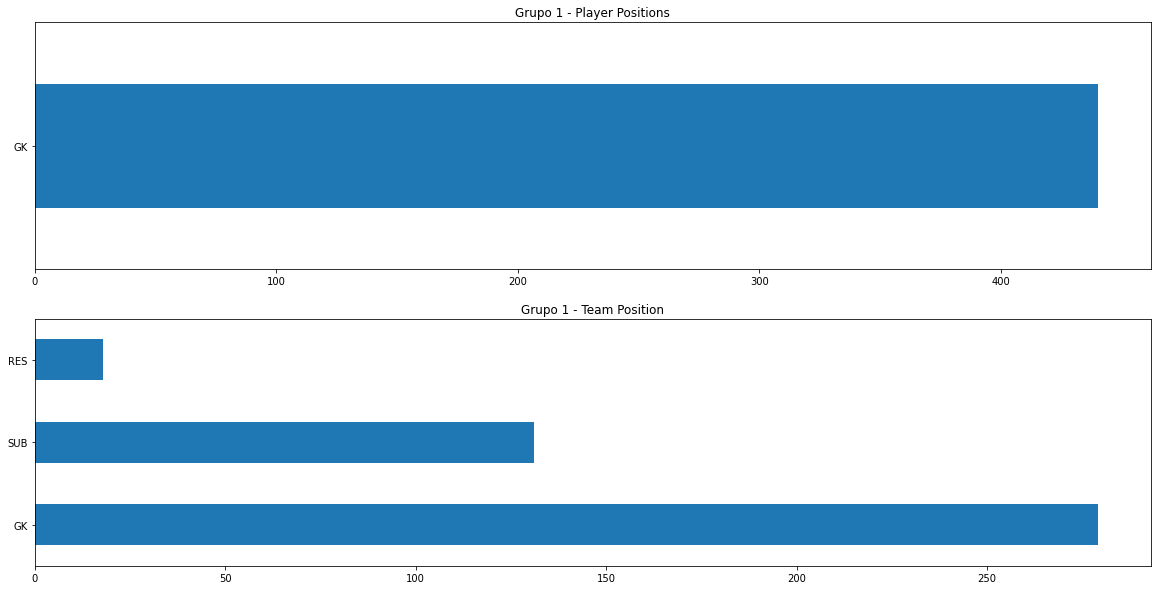

In [14]:
(fig, axs) = plt.subplots(2, 1, figsize=(25, 20), sharey=False)
player_positions_series_from_group(df_cluster_kmean,
                                   group_label=1).value_counts().plot(kind='barh', figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 1 - Player Positions')

column = 'team_position'

get_colum_series_by_group(df_cluster_kmean, column,
                          group_label=1).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 1 - Team Position')
df_km_group_1 = df_cluster_kmean[df_cluster_kmean.group_label == 1]
df_km_group_1[skills_ratings].describe()




#### Conclusión Grupo 1:
Este grupo indudablemente esta formado solamente por jugadores que juegan una única posición, Arqueros. Tienen buenas puntuaciones en los skills relacionados a arqueros y defensa pero bajos skills de ataque.

### Grupo 2



,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,0.0,0.0,0.0,0.0,0.0,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,69.167820,57.356401,62.034025,70.884083,75.006920,56.095732,72.855825,72.158016,66.445790,59.156863,74.588812,70.372549,69.820646,71.741061,73.100346,70.803922,71.403691,69.006344,77.648212,69.157439,65.237601,72.514418,70.903691,66.135525,69.226067,58.450404,72.168973,68.907728,71.522491,68.728374,NaN,NaN,NaN,NaN,NaN,10.627451,10.651672,10.792964,10.726644,10.654556
std,8.305136,10.700824,9.887801,5.146313,5.029051,11.874077,4.899095,5.977873,10.249017,13.284219,4.869670,10.393230,11.016727,8.267831,5.113515,9.789809,8.341161,10.660228,8.743291,8.945498,10.246306,8.940179,6.925826,7.684907,8.159807,11.006981,6.480985,7.937408,6.730001,8.229507,NaN,NaN,NaN,NaN,NaN,3.673750,3.503984,3.414834,3.691230,3.387128
min,40.000000,20.000000,22.000000,57.000000,58.000000,21.000000,56.000000,43.000000,31.000000,21.000000,55.000000,30.000000,29.000000,33.000000,56.000000,31.000000,32.000000,30.000000,33.000000,29.000000,26.000000,34.000000,44.000000,30.000000,39.000000,22.000000,51.000000,25.000000,44.000000,36.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
25%,64.000000,50.000000,56.000000,68.000000,72.000000,48.000000,70.000000,68.000000,60.000000,49.000000,71.000000,65.000000,64.000000,67.000000,70.000000,65.000000,66.250000,63.000000,73.000000,64.000000,59.000000,67.000000,67.000000,62.000000,65.000000,51.000000,68.000000,65.000000,68.000000,65.000000,NaN,NaN,NaN,NaN,NaN,8.000000,8.000000,8.000000,8.000000,8.000000
50%,70.000000,59.000000,62.000000,71.000000,75.000000,57.000000,73.000000,72.000000,67.000000,60.000000,74.000000,71.000000,71.000000,72.000000,73.000000,72.000000,72.000000,70.000000,78.000000,69.000000,67.000000,73.000000,71.000000,67.000000,70.000000,59.000000,72.000000,70.000000,72.000000,70.000000,NaN,NaN,NaN,NaN,NaN,11.000000,11.000000,11.000000,11.000000,11.000000
75%,75.000000,65.000000,69.000000,74.000000,78.000000,65.000000,76.000000,76.000000,74.000000,69.000000,77.000000,77.000000,77.000000,77.000000,76.000000,77.000000,77.000000,76.000000,84.000000,75.000000,73.000000,79.000000,75.000000,71.000000,75.000000,66.000000,76.000000,74.000000,76.000000,74.000000,NaN,NaN,NaN,NaN,NaN,13.000000,13.000000,13.000000,13.000000,13.000000
max,93.000000,85.000000,92.000000,92.000000,92.000000,87.000000,91.000000,92.000000,92.000000,92.000000,93.000000,94.000000,94.000000,94.000000,93.000000,94.000000,95.000000,94.000000,97.000000,92.000000,90.000000,95.000000,92.000000,90.000000,94.000000,91.000000,95.000000,91.000000,92.000000,90.000000,NaN,NaN,NaN,NaN,NaN,75.000000,62.000000,54.000000,71.000000,48.000000


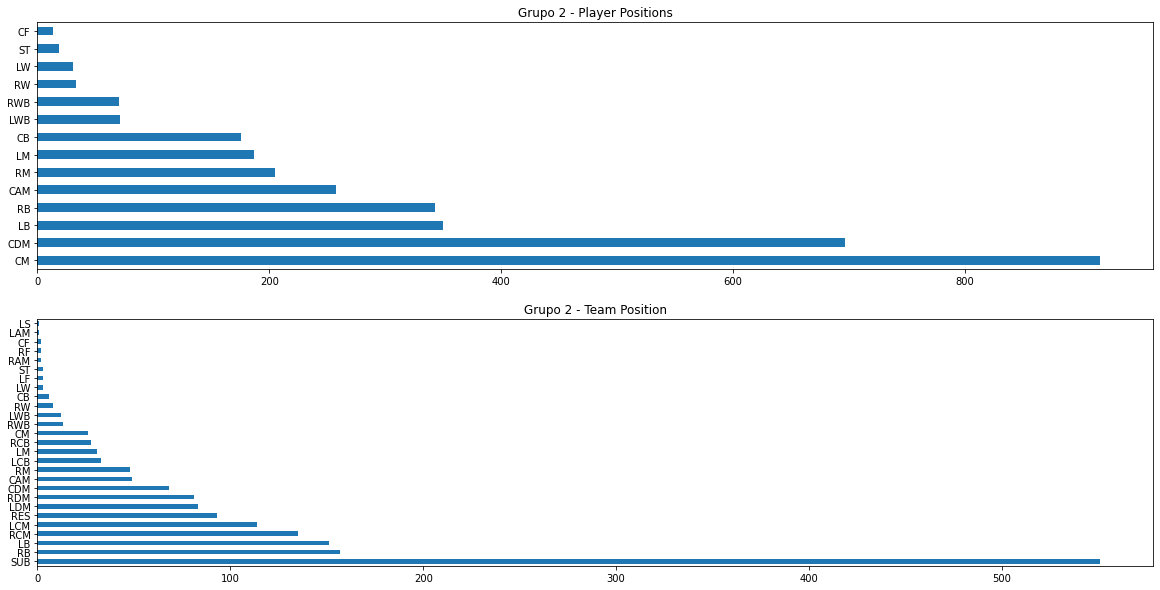

In [15]:
(fig, axs) = plt.subplots(2, 1, figsize=(25, 20), sharey=False)
player_positions_series_from_group(df_cluster_kmean,
                                   group_label=2).value_counts().plot(kind='barh', figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 2 - Player Positions')

column = 'team_position'

get_colum_series_by_group(df_cluster_kmean, column,
                          group_label=2).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 2 - Team Position')
df_km_group_2 = df_cluster_kmean[df_cluster_kmean.group_label == 2]
df_km_group_2[skills_ratings].describe()

#### Conclusión Grupo 2:
Este grupo podemos observar que en su mayor parte se encuentra jugadores de medio campo de los cuales una parte tambien puede desempeñar actividades de defensa. Aca se puede rescatar algo particular los jugadores de medio campo presentan habilidades variadas que le permiten estar entre posiciones de defensa o delanteros.

### Grupo 3


,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.00000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,0.0,0.0,0.0,0.0,0.0,923.000000,923.000000,923.000000,923.000000,923.000000
mean,46.876490,34.786566,72.679307,55.556880,66.310943,34.817985,57.157096,53.304442,41.267606,37.036836,62.479957,57.613218,60.333694,55.32286,69.793066,54.432286,56.767064,72.970748,68.458288,79.463705,40.369447,75.969664,73.656555,40.366197,48.572048,44.397616,67.602384,73.528711,75.277356,72.981582,NaN,NaN,NaN,NaN,NaN,10.664139,10.842904,10.729144,10.802817,10.627302
std,13.484542,9.595674,6.596610,7.020713,6.515937,10.065265,7.543239,10.104844,11.636155,11.822473,6.816655,12.135931,12.576673,11.42607,5.087038,11.695639,11.813487,11.374430,10.346447,6.792041,13.152906,6.984423,4.721315,11.685049,11.416392,10.607935,6.672789,4.862534,4.255021,4.684479,NaN,NaN,NaN,NaN,NaN,3.466274,3.340448,3.650140,3.538464,3.280421
min,11.000000,13.000000,40.000000,34.000000,44.000000,11.000000,34.000000,22.000000,13.000000,10.000000,34.000000,28.000000,29.000000,26.00000,55.000000,26.000000,15.000000,30.000000,29.000000,57.000000,12.000000,39.000000,61.000000,12.000000,13.000000,13.000000,32.000000,62.000000,63.000000,57.000000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,2.000000,3.000000,3.000000
25%,36.000000,27.000000,70.000000,51.000000,62.000000,28.000000,52.000000,47.000000,32.000000,28.500000,58.000000,51.000000,52.000000,49.00000,67.000000,46.000000,48.000000,68.000000,63.000000,75.000000,30.000000,72.000000,70.000000,31.000000,41.000000,37.000000,64.000000,70.000000,72.000000,70.000000,NaN,NaN,NaN,NaN,NaN,8.000000,8.000000,8.000000,8.000000,8.000000
50%,46.000000,35.000000,73.000000,56.000000,67.000000,34.000000,58.000000,55.000000,40.000000,35.000000,63.000000,60.000000,63.000000,57.00000,70.000000,56.000000,57.000000,75.000000,69.000000,79.000000,40.000000,76.000000,73.000000,40.000000,49.000000,44.000000,68.000000,73.000000,75.000000,73.000000,NaN,NaN,NaN,NaN,NaN,11.000000,11.000000,11.000000,11.000000,11.000000
75%,56.500000,41.000000,77.000000,61.000000,71.000000,41.000000,63.000000,61.000000,49.000000,43.000000,67.000000,66.000000,68.000000,64.00000,73.000000,63.000000,65.000000,80.000000,75.000000,84.000000,50.500000,81.000000,77.000000,50.000000,57.000000,50.000000,72.000000,76.000000,78.000000,76.000000,NaN,NaN,NaN,NaN,NaN,13.000000,13.000000,13.000000,14.000000,13.000000
max,78.000000,60.000000,90.000000,73.000000,82.000000,72.000000,76.000000,77.000000,76.000000,79.000000,80.000000,90.000000,90.000000,90.00000,86.000000,91.000000,89.000000,94.000000,93.000000,95.000000,78.000000,92.000000,88.000000,70.000000,75.000000,79.000000,86.000000,94.000000,91.000000,89.000000,NaN,NaN,NaN,NaN,NaN,58.000000,40.000000,64.000000,56.000000,43.000000


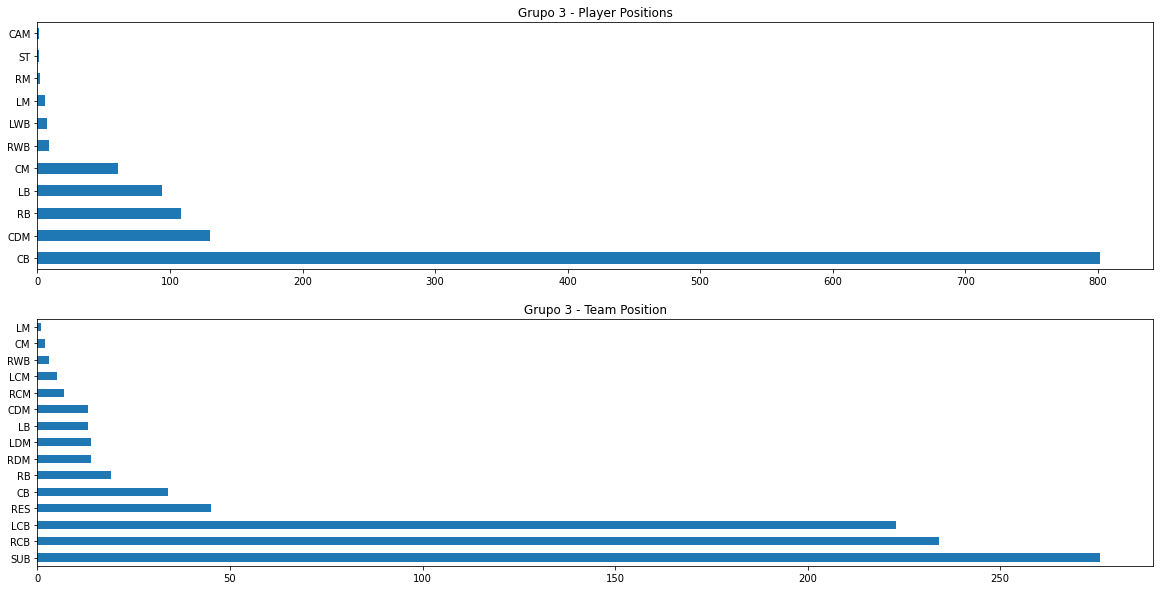

In [16]:
(fig, axs) = plt.subplots(2, 1, figsize=(25, 20), sharey=False)
player_positions_series_from_group(df_cluster_kmean,
                                   group_label=3).value_counts().plot(kind='barh', figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 3 - Player Positions')

column = 'team_position'

get_colum_series_by_group(df_cluster_kmean, column,
                          group_label=3).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 3 - Team Position')
df_km_group_3 = df_cluster_kmean[df_cluster_kmean.group_label == 3]
df_km_group_3[skills_ratings].describe()

#### Conclusión Grupo 3:
Este grupo podemos observar que en su mayor juega en posiciones de Defensores (CB, LB, RB). 
Se puede encontrar muy pocos jugadores que puden desempeñarse como medio campistas (CM)


### Tabla de contingencia. Variable Categórica vs Cluster

In [17]:
pd.crosstab(index=df_cluster_kmean['team_position'],
            columns=df_cluster_kmean['group_label'], margins=True)

group_label,0,1,2,3,All
team_position,,,,,
CAM,99,0,49,0,148
CB,0,0,6,34,40
CDM,1,0,68,13,82
CF,7,0,2,0,9
CM,2,0,26,2,30
GK,0,279,0,0,279
LAM,12,0,1,0,13
LB,0,0,151,13,164
LCB,0,0,33,223,256


### Silohuette

For n_clusters = 4 The average silhouette_score is : 0.3368326111602603


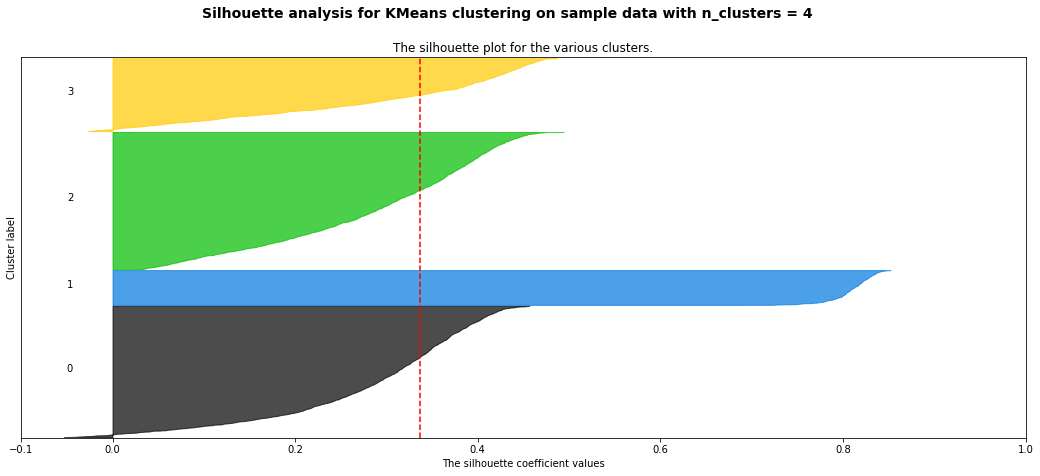

In [18]:
title = "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_cluster_kmean

print_Silohuette(n_cluster_kmean, km.labels_, df_skills, title)

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [19]:
n_samples = len(df_skills)
X = StandardScaler().fit_transform(df_skills)
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=n_samples)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )

pipe.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_mean_shift)

Numero estimado de clusters para Mean Shift : 3


In [20]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
#skill_1=skills_ratings[5]
#skill_2=skills_ratings[14]
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [21]:
df_cluster_mean_shift=df_n.copy().fillna(0)
df_cluster_mean_shift['group_label'] = ms.labels_ #clusters
n_clusater_mean_shift = max(ms.labels_)+1
print('Mean shift encontró ', n_clusater_mean_shift , 'clusters, según los hiperparámetros elegidos')

Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

Cantidad de observaciones por Cluster

Análisis descriptivo separando por Cluster

Tabla de contingencia alguna categórica vs clusters

Silohuette?


### Cantidad de observaciones por Cluster

In [22]:
df_cluster_count = df_cluster_mean_shift.groupby(by=['group_label']).count()[['sofifa_id']]
df_cluster_count.columns = ['observaciones']
df_cluster_count

,observaciones
group_label,
0,4313
1,1
2,442


### Análisis descriptivo por cluster
#### Cluster 0:


,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.0,4313.0,4313.0,4313.0,4313.0,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000
mean,62.676096,58.222119,63.971250,66.087642,71.499420,55.701368,70.322050,69.303269,61.348018,54.817065,72.258521,69.781359,69.985161,69.885231,71.882448,67.681892,69.358219,69.003710,72.732901,70.257361,61.379782,67.539068,57.610248,63.578484,64.575701,58.773012,70.867146,57.511245,57.880362,54.724322,0.0,0.0,0.0,0.0,0.0,10.575470,10.658938,10.695108,10.626014,10.564572
std,13.673425,16.530003,11.900177,8.730782,6.604874,15.775952,9.026678,11.026799,15.019442,16.125096,7.460296,12.873842,12.420966,12.555426,5.575577,13.190199,10.886810,11.948016,10.004872,11.649093,14.901983,13.330149,19.955446,14.971987,12.240266,13.099862,6.860370,18.888071,20.719056,21.429552,0.0,0.0,0.0,0.0,0.0,3.125679,3.131373,3.167702,3.178070,3.169247
min,11.000000,13.000000,20.000000,34.000000,44.000000,11.000000,34.000000,22.000000,13.000000,10.000000,34.000000,28.000000,29.000000,26.000000,54.000000,26.000000,15.000000,29.000000,29.000000,27.000000,12.000000,22.000000,10.000000,12.000000,13.000000,13.000000,32.000000,10.000000,10.000000,10.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
25%,56.000000,47.000000,56.000000,61.000000,67.000000,44.000000,66.000000,65.000000,52.000000,42.000000,69.000000,63.000000,64.000000,63.000000,68.000000,60.000000,64.000000,63.000000,67.000000,64.000000,55.000000,60.000000,39.000000,58.000000,58.000000,49.000000,66.000000,41.000000,38.000000,33.000000,0.0,0.0,0.0,0.0,0.0,8.000000,8.000000,8.000000,8.000000,8.000000
50%,66.000000,63.000000,66.000000,68.000000,72.000000,59.000000,72.000000,72.000000,65.000000,56.000000,73.000000,71.000000,71.000000,72.000000,72.000000,69.000000,72.000000,70.000000,73.000000,71.000000,66.000000,70.000000,67.000000,68.000000,67.000000,60.000000,71.000000,65.000000,68.000000,65.000000,0.0,0.0,0.0,0.0,0.0,11.000000,11.000000,11.000000,11.000000,11.000000
75%,72.000000,71.000000,73.000000,72.000000,76.000000,68.000000,76.000000,76.000000,72.000000,68.000000,77.000000,78.000000,78.000000,78.000000,75.000000,77.000000,77.000000,77.000000,79.000000,78.000000,72.000000,77.000000,73.000000,74.000000,73.000000,69.000000,75.000000,72.000000,74.000000,72.000000,0.0,0.0,0.0,0.0,0.0,13.000000,13.000000,13.000000,13.000000,13.000000
max,93.000000,95.000000,93.000000,92.000000,92.000000,90.000000,96.000000,97.000000,94.000000,94.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,97.000000,95.000000,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,92.000000,90.000000,0.0,0.0,0.0,0.0,0.0,32.000000,33.000000,38.000000,33.000000,37.000000


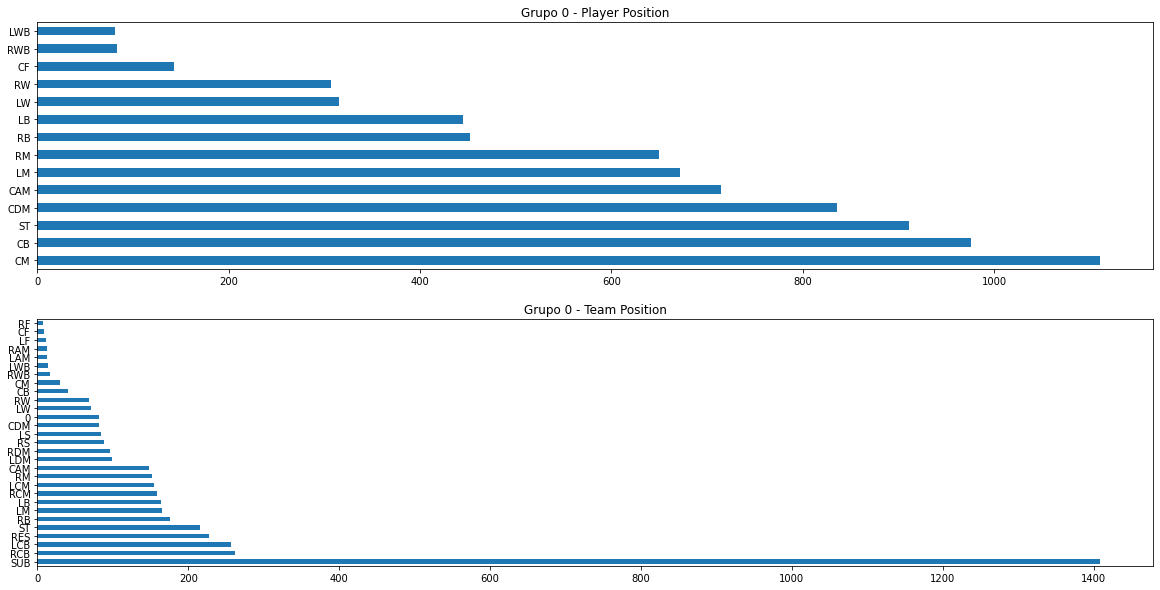

In [23]:
(fig, axs) = plt.subplots(2, 1, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_cluster_mean_shift,
                                   group_label=0).value_counts().plot(kind='barh',
        figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 0 - Player Position')

column = 'team_position'
get_colum_series_by_group(df_cluster_mean_shift, column,
                          group_label=0).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 0 - Team Position')

df_ms_group_0 = df_cluster_mean_shift[df_cluster_mean_shift.group_label== 0]
df_ms_group_0[skills_ratings].describe()


#### Conclusión Grupo 0:
Mediante Mean Shift se puede observar algo particular. Solo pudimos separar el data set en do grupos. Los Aqueros del resto. En este grupo de encuentran incluidos todos los jugadores que no juegan en una posición de arqueros.

### Grupo 1

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0
25%,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0
50%,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0
75%,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0
max,79.0,48.0,69.0,69.0,71.0,49.0,78.0,78.0,55.0,49.0,75.0,81.0,75.0,82.0,81.0,75.0,52.0,51.0,85.0,62.0,56.0,62.0,77.0,57.0,61.0,41.0,54.0,78.0,77.0,76.0,0.0,0.0,0.0,0.0,0.0,75.0,53.0,42.0,60.0,45.0


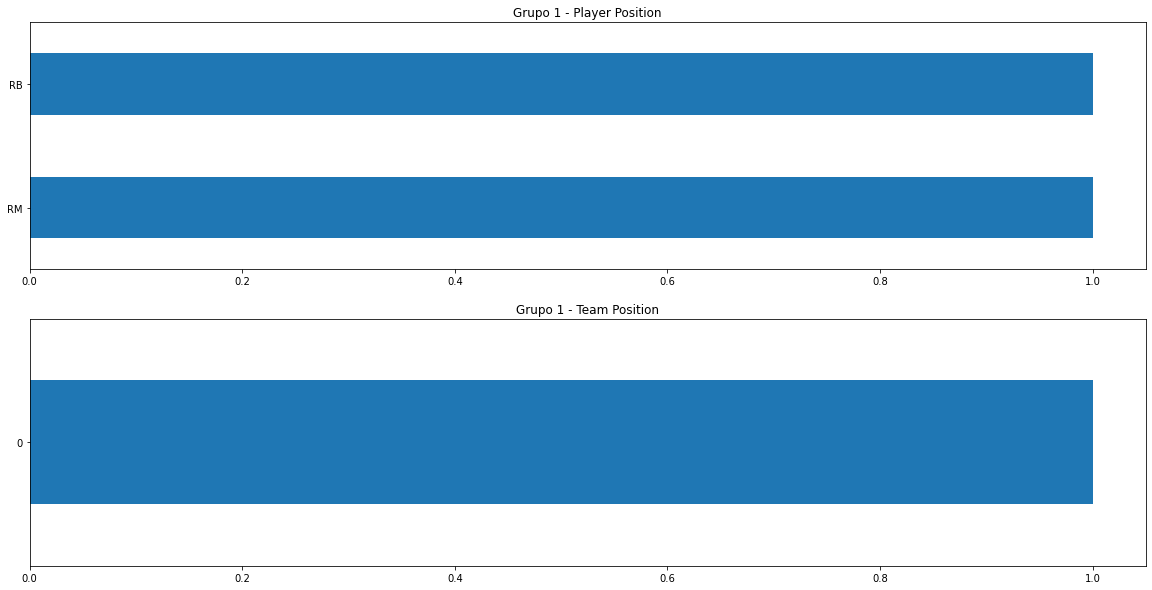

In [24]:
(fig, axs) = plt.subplots(2, 1, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_cluster_mean_shift,
                                   group_label=1).value_counts().plot(kind='barh',
        figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 1 - Player Position')

column = 'team_position'
get_colum_series_by_group(df_cluster_mean_shift, column,
                          group_label=1).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 1 - Team Position')

df_ms_group_1 = df_cluster_mean_shift[df_cluster_mean_shift.group_label== 1]
df_ms_group_1[skills_ratings].describe()

#### Conclusión Grupo 1:
En este grupo solo se incluyo un único registro. Consideramos que puede llegar a ser un outlier.

### Grupo 2

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.0000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,15.058824,13.328054,15.210407,0.255656,30.533937,13.886878,0.287330,15.592760,15.934389,15.208145,22.972851,44.626697,44.595023,46.404977,71.178733,45.040724,52.893665,64.993213,34.081448,66.0181,14.124434,29.685520,19.997738,12.916290,46.468326,22.341629,53.966063,17.203620,14.891403,14.644796,75.423077,72.386878,69.961538,73.995475,76.873303,75.685520,72.617647,70.228507,74.282805,77.079186
std,4.773906,4.048300,6.214136,3.796439,9.071646,4.344137,4.267822,5.136834,5.989616,5.673435,7.150103,9.392114,9.199047,12.076148,5.481960,10.406398,4.920687,10.054159,7.010369,9.6261,4.178054,8.744456,6.473914,4.272971,12.628124,7.650147,11.515590,6.587915,5.725542,5.427576,6.794336,6.792827,7.947724,6.826650,7.000309,4.655304,4.994869,6.446346,4.737473,5.162710
min,6.000000,5.000000,7.000000,0.000000,11.000000,5.000000,0.000000,7.000000,6.000000,4.000000,5.000000,15.000000,16.000000,14.000000,55.000000,20.000000,32.000000,32.000000,13.000000,26.0000,5.000000,11.000000,7.000000,3.000000,10.000000,9.000000,17.000000,7.000000,7.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,40.000000,43.000000,56.000000,43.000000
25%,12.000000,11.000000,12.000000,0.000000,25.000000,11.000000,0.000000,12.000000,12.000000,12.000000,19.000000,38.000000,38.000000,37.000000,68.000000,38.000000,50.000000,60.000000,30.000000,60.0000,12.000000,23.000000,16.000000,11.000000,39.250000,18.000000,50.000000,13.000000,12.000000,12.000000,72.000000,69.000000,66.000000,71.000000,74.000000,72.000000,69.000000,66.000000,71.000000,74.000000
50%,14.000000,13.000000,14.000000,0.000000,30.000000,13.000000,0.000000,15.000000,15.000000,14.000000,22.000000,45.000000,45.000000,45.000000,71.000000,45.000000,53.000000,67.000000,34.000000,68.0000,14.000000,29.000000,20.000000,13.000000,46.000000,22.000000,57.000000,16.000000,14.000000,14.000000,75.000000,72.000000,70.000000,74.000000,77.000000,75.000000,72.000000,70.000000,74.000000,77.000000
75%,18.000000,15.000000,17.000000,0.000000,35.000000,16.000000,0.000000,18.000000,18.000000,17.000000,26.000000,50.750000,50.000000,56.000000,74.000000,53.000000,56.000000,72.000000,40.000000,72.0000,16.000000,36.000000,23.750000,15.000000,55.000000,25.000000,62.000000,20.000000,17.000000,16.000000,79.000000,75.000000,75.000000,77.000000,80.000000,79.000000,75.000000,75.000000,77.000000,80.000000
max,40.000000,56.000000,83.000000,57.000000,74.000000,63.000000,65.000000,60.000000,72.000000,74.000000,72.000000,83.000000,78.000000,77.000000,88.000000,69.000000,74.000000,91.000000,76.000000,85.0000,61.000000,86.000000,82.000000,58.000000,72.000000,62.000000,71.000000,84.000000,85.000000,82.000000,90.000000,92.000000,93.000000,91.000000,92.000000,90.000000,92.000000,93.000000,91.000000,92.000000


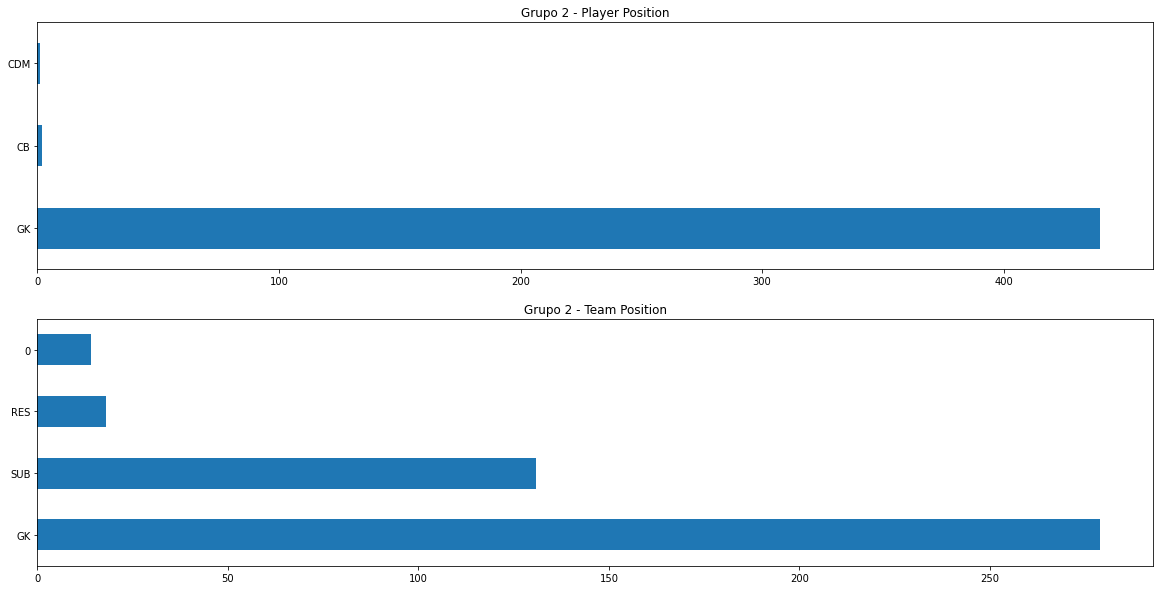

In [25]:
(fig, axs) = plt.subplots(2, 1, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_cluster_mean_shift,
                                   group_label=2).value_counts().plot(kind='barh',
        figsize=(20, 10), ax=axs[0])
axs[0].set_title('Grupo 2 - Player Position')

column = 'team_position'
get_colum_series_by_group(df_cluster_mean_shift, column,
                          group_label=2).value_counts().plot(kind='barh', ax=axs[1])
axs[1].set_title('Grupo 2 - Team Position')

df_ms_group_2 = df_cluster_mean_shift[df_cluster_mean_shift.group_label== 2]
df_ms_group_2[skills_ratings].describe()

#### Conclusión Grupo 2:
Como lo comentamos en la conclusión del grupo 0. Este grupo se puede observar solamente arqueros junto con una pequeña porcion de defensores centrales (CB). Esos defensores pueden llegar a ser un outlier dentro del grupo de defensores lo que llevo al algoritmo a agrupamiento a introducirlo en este grupo.


### Tabla de Contigencia categoria - cluster

In [26]:
pd.crosstab(index=df_cluster_mean_shift['team_position'],
            columns=df_cluster_mean_shift['group_label'], margins=True)

group_label,0,1,2,All
team_position,,,,
0,82,1,14,97
CAM,148,0,0,148
CB,40,0,0,40
CDM,82,0,0,82
CF,9,0,0,9
CM,30,0,0,30
GK,0,0,279,279
LAM,13,0,0,13
LB,164,0,0,164


### Silhouette

For n_clusters = 3 The average silhouette_score is : 0.3389568961372762


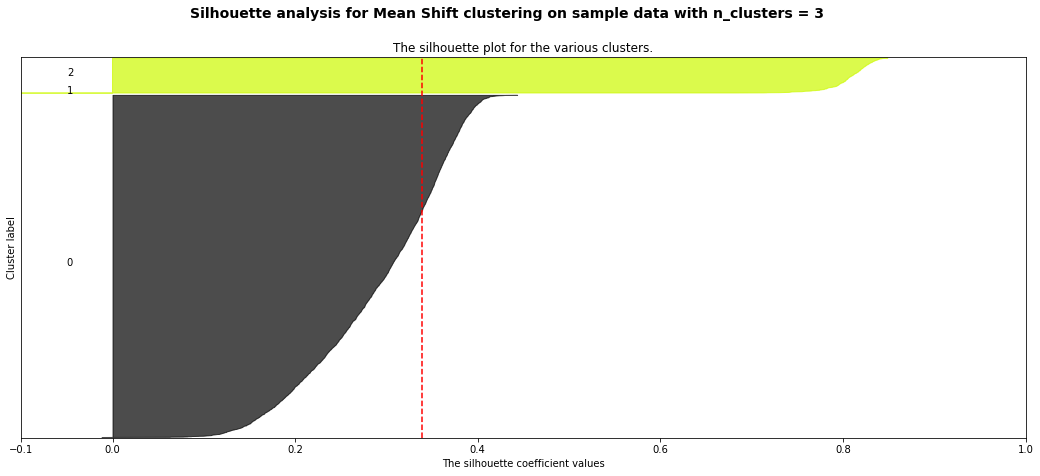

In [28]:
title = "Silhouette analysis for Mean Shift clustering on sample data with n_clusters = %d" % n_clusters_mean_shift

print_Silohuette(n_clusters_mean_shift, ms.labels_, df_skills, title)

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [29]:
n=10000

df_temp = df.loc[:n]
df_without_GK=df_temp[(df_temp["team_position"]!='GK')&(df_temp['overall']>69)]

#skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  ]

df_skills_without_GK=df_without_GK[skills_ratings]
df_skills_without_GK = df_skills_without_GK.fillna(0)
df_skills_without_GK.isna().sum()

attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
passing                       0
attacking_short_passing       0
attacking_volleys             0
dribbling                     0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_shot_power              0
power_jumping                 0
power_stamina                 0
power_strength                0
power_long_shots              0
mentality_aggression          0
mentality_interceptions       0
mentality_positioning         0
mentality_vision              0
mentality_penalties           0
mentality_composure           0
defending_marking             0
defending_standing_tackle     0
defending_sliding_tackle      0
dtype: int64

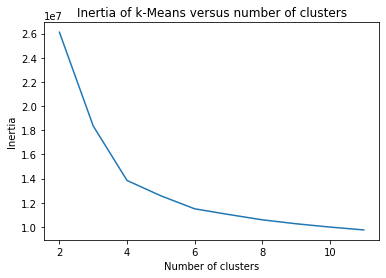

In [30]:
print_kmeans_inertia(df_skills_without_GK)

In [31]:
# Número de clusters buscado
n_clusters = 5

km_no_GK = KMeans(n_clusters=n_clusters)
km_no_GK.fit(df_skills_without_GK)

# Recuperacion de etiquetas
clusters = km_no_GK.labels_


In [32]:
data=[]
bool_crack=df_without_GK["overall"] > 85
bool_no_crack=df_without_GK["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


kmean_clusters = go.Scatter(x=df_skills_without_GK[skill_1], y=df_skills_without_GK[skill_2],
                           mode='markers',
                        text=df_without_GK.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_without_GK.loc[bool_crack,skill_1], y=df_skills_without_GK.loc[bool_crack,skill_2],name='Top players',
                      text=df_without_GK.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Text(0.5, 1.0, 'Grupo 4 - Player Position')

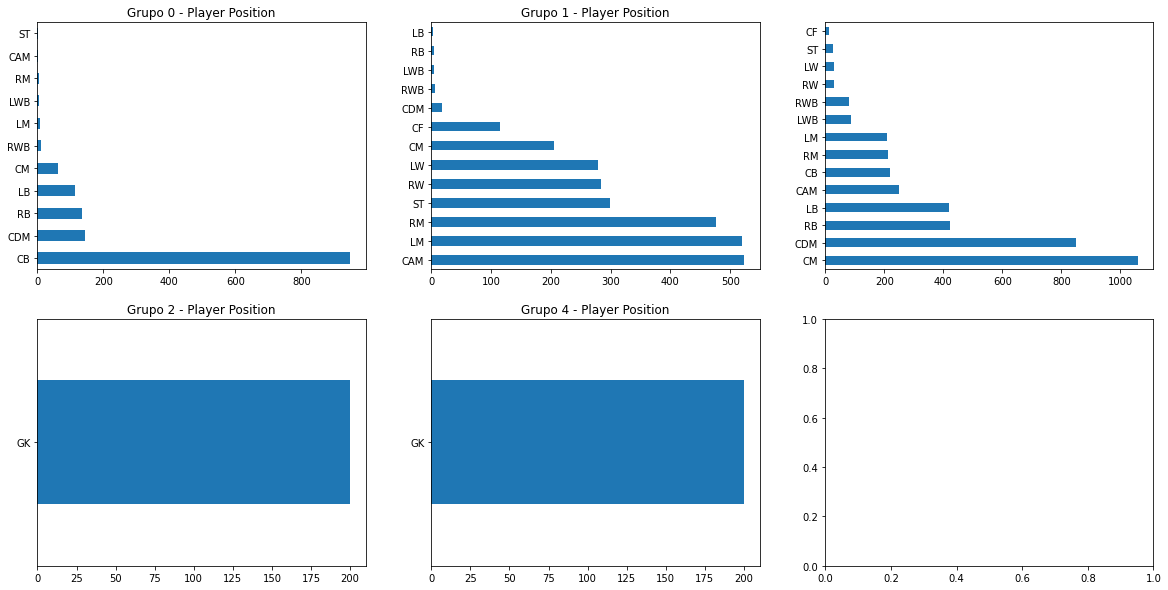

In [33]:
df_km_no_GK=df_without_GK.copy()
df_km_no_GK['group_label'] = km_no_GK.labels_

fig, axs = plt.subplots(2, 3, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_km_no_GK, 0).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][0] )
axs[0][0].set_title('Grupo 0 - Player Position')
player_positions_series_from_group(df_km_no_GK, 1).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][1] )
axs[0][1].set_title('Grupo 1 - Player Position')
player_positions_series_from_group(df_km_no_GK, 2).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][2] )
axs[1][0].set_title('Grupo 2 - Player Position')
player_positions_series_from_group(df_km_no_GK, 3).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][0] )
axs[1][1].set_title('Grupo 3 - Player Position')
player_positions_series_from_group(df_km_no_GK, 3).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][1] )
axs[1][1].set_title('Grupo 4 - Player Position')

<AxesSubplot:title={'center':'Group 4 - team_position'}>

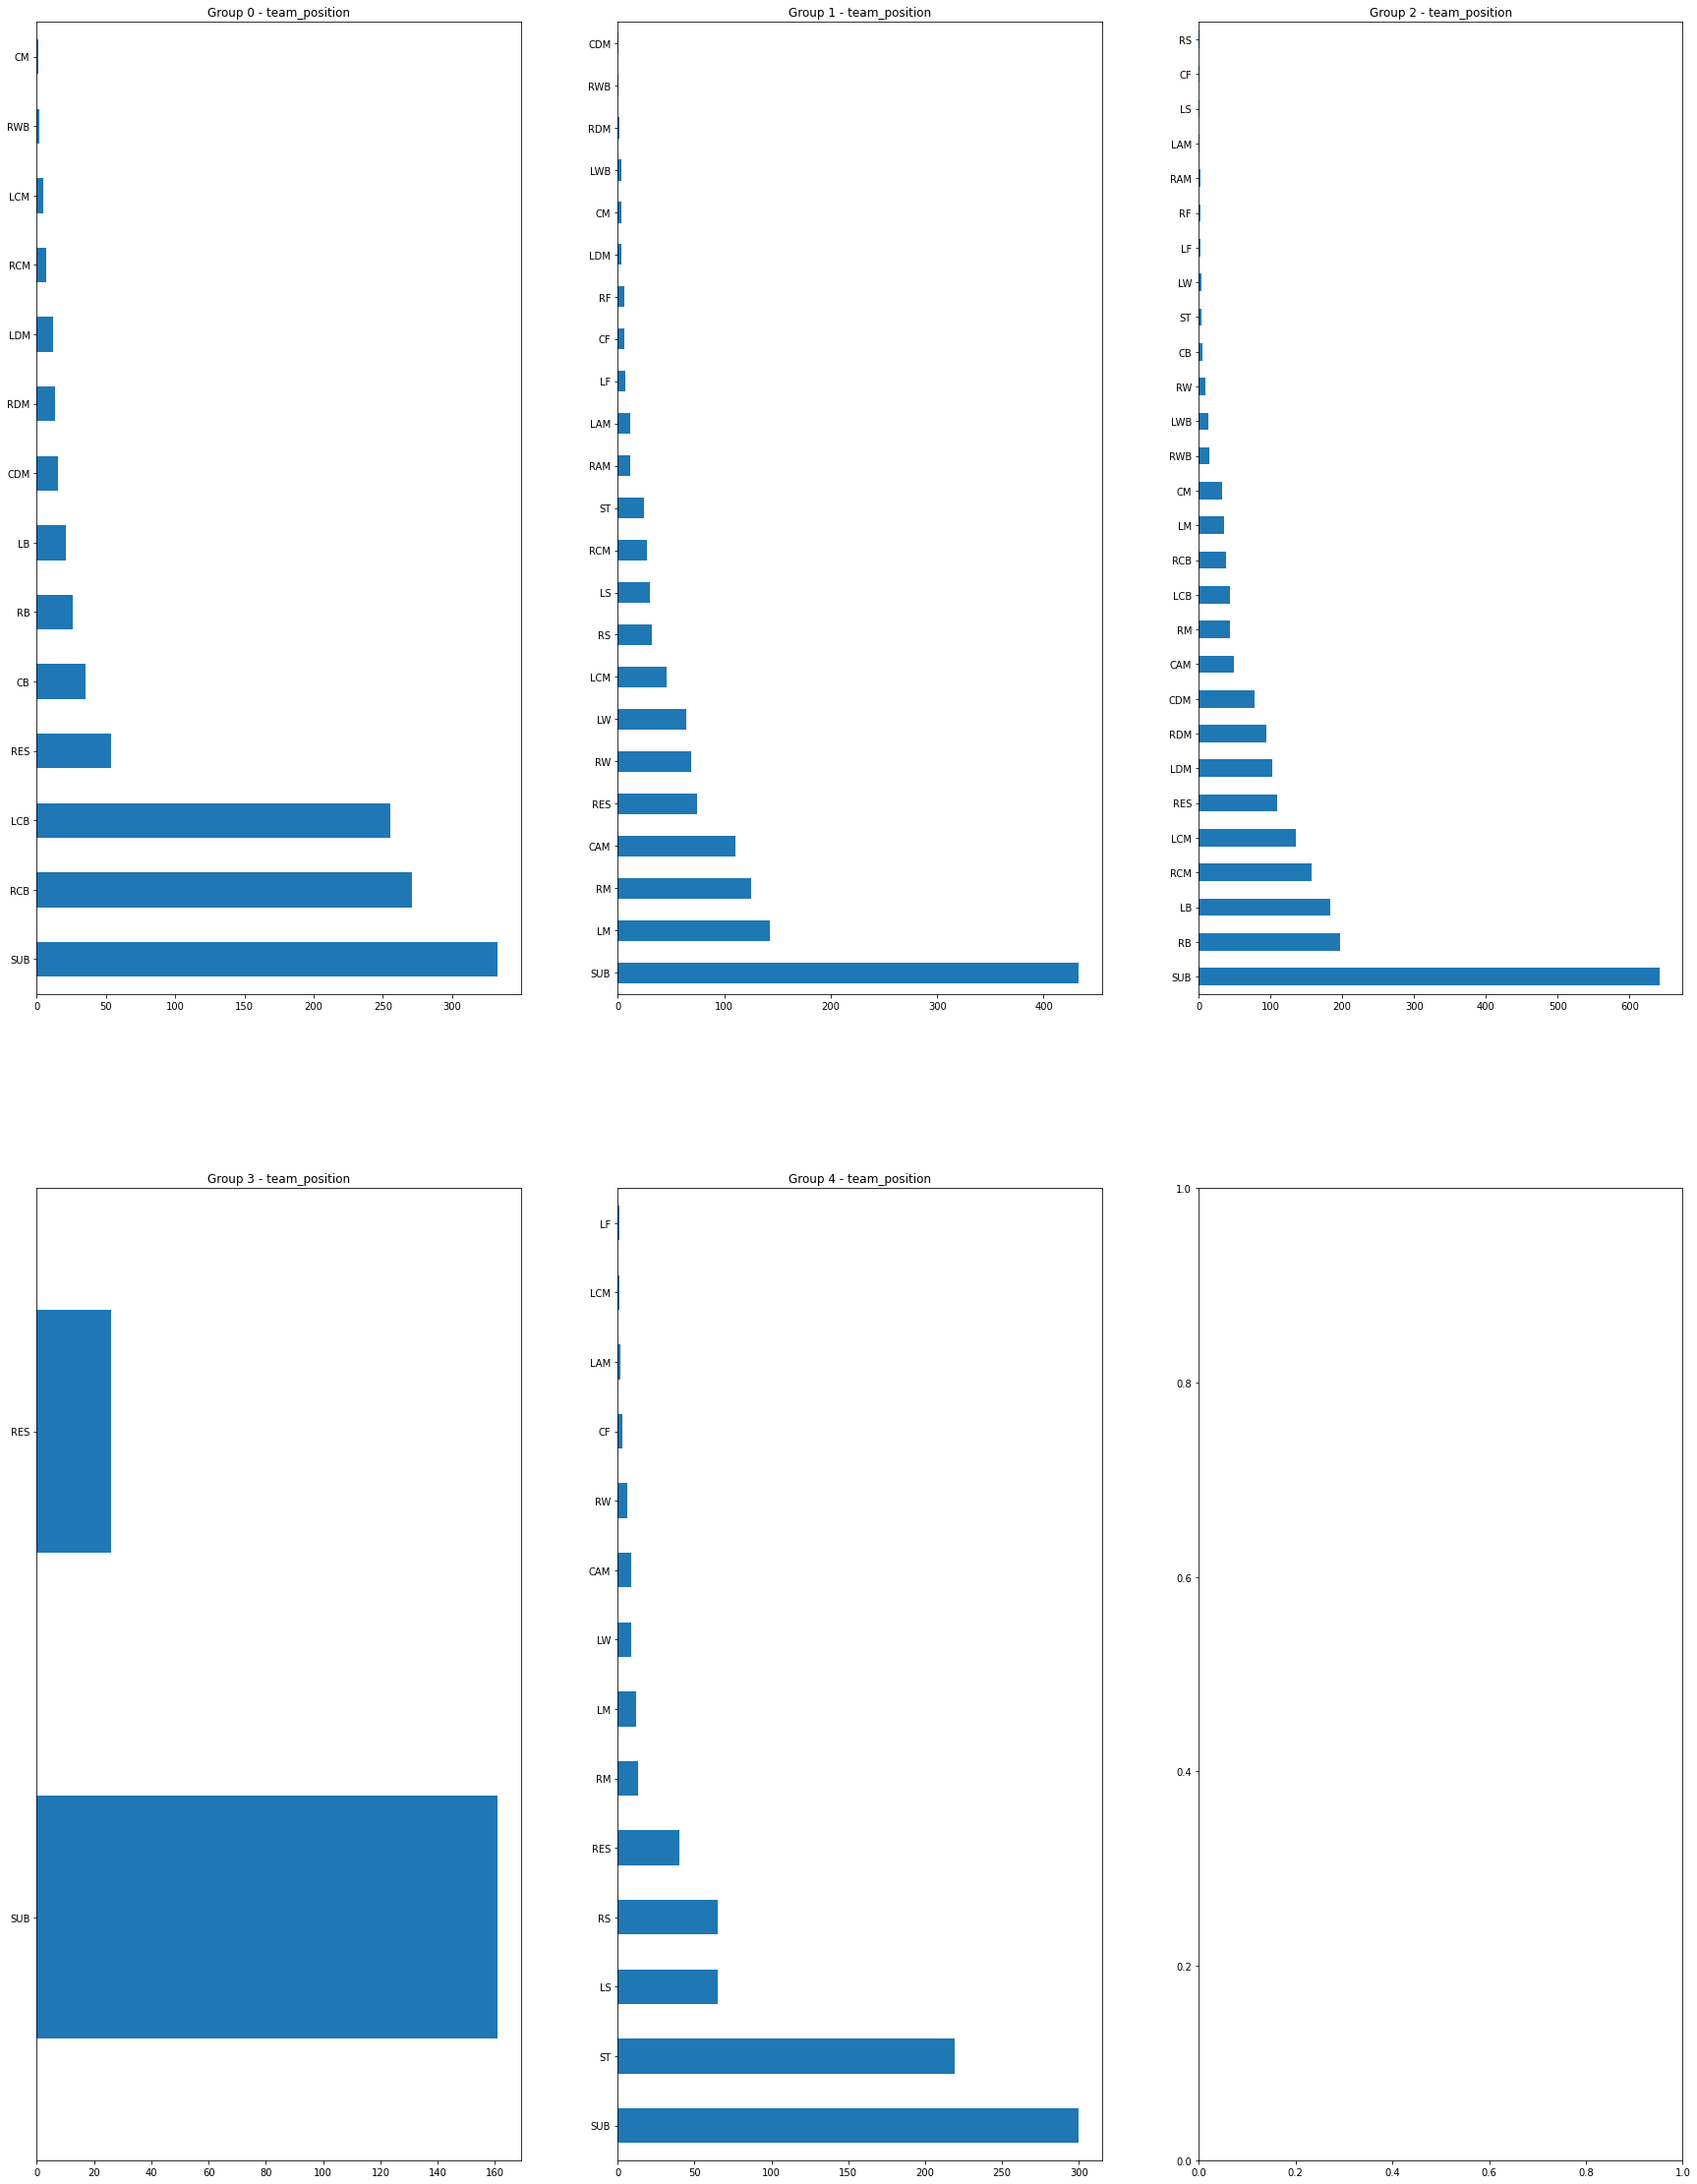

In [36]:
column_name = 'team_position'
(fig, axs) = plt.subplots(2, 3, figsize=(30, 40), sharey=False)
get_colum_series_by_group(df_km_no_GK, column_name,
                          0).value_counts().plot(kind='barh',
        title='Group 0 - team_position', ax=axs[0][0])
get_colum_series_by_group(df_km_no_GK, column_name,
                          1).value_counts().plot(kind='barh',
        title='Group 1 - team_position', ax=axs[0][1])
get_colum_series_by_group(df_km_no_GK, column_name,
                          2).value_counts().plot(kind='barh',
        title='Group 2 - team_position', ax=axs[0][2])
get_colum_series_by_group(df_km_no_GK, column_name,
                          3).value_counts().plot(kind='barh',
        title='Group 3 - team_position', ax=axs[1][0])
get_colum_series_by_group(df_km_no_GK, column_name,
                          4).value_counts().plot(kind='barh',
        title='Group 4 - team_position', ax=axs[1][1])

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [37]:
n_samples = len(df_skills_without_GK)
X = StandardScaler().fit_transform(df_skills_without_GK)
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=n_samples)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
#pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )
pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )

pipe.fit(df_skills_without_GK)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d \nBrandwidth: %d"%(n_clusters_mean_shift, bandwidth))

Numero estimado de clusters para Mean Shift : 1 
Brandwidth: 4


In [38]:
bandwidth = 2
ms_no_GK = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_no_GK.fit(df_skills_without_GK)

clusters2 = ms_no_GK.labels_
cluster_centers = ms_no_GK.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d \nBrandwidth: %d"%(n_clusters_mean_shift, bandwidth))


Numero estimado de clusters para Mean Shift : 8 
Brandwidth: 2


In [39]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [40]:
df_ms_no_GK=df_without_GK.copy()
df_ms_no_GK['group_label'] = ms_no_GK.labels_



### Análisis exploratorio de las clases - Mean Shift

<AxesSubplot:title={'center':'Group 7'}>

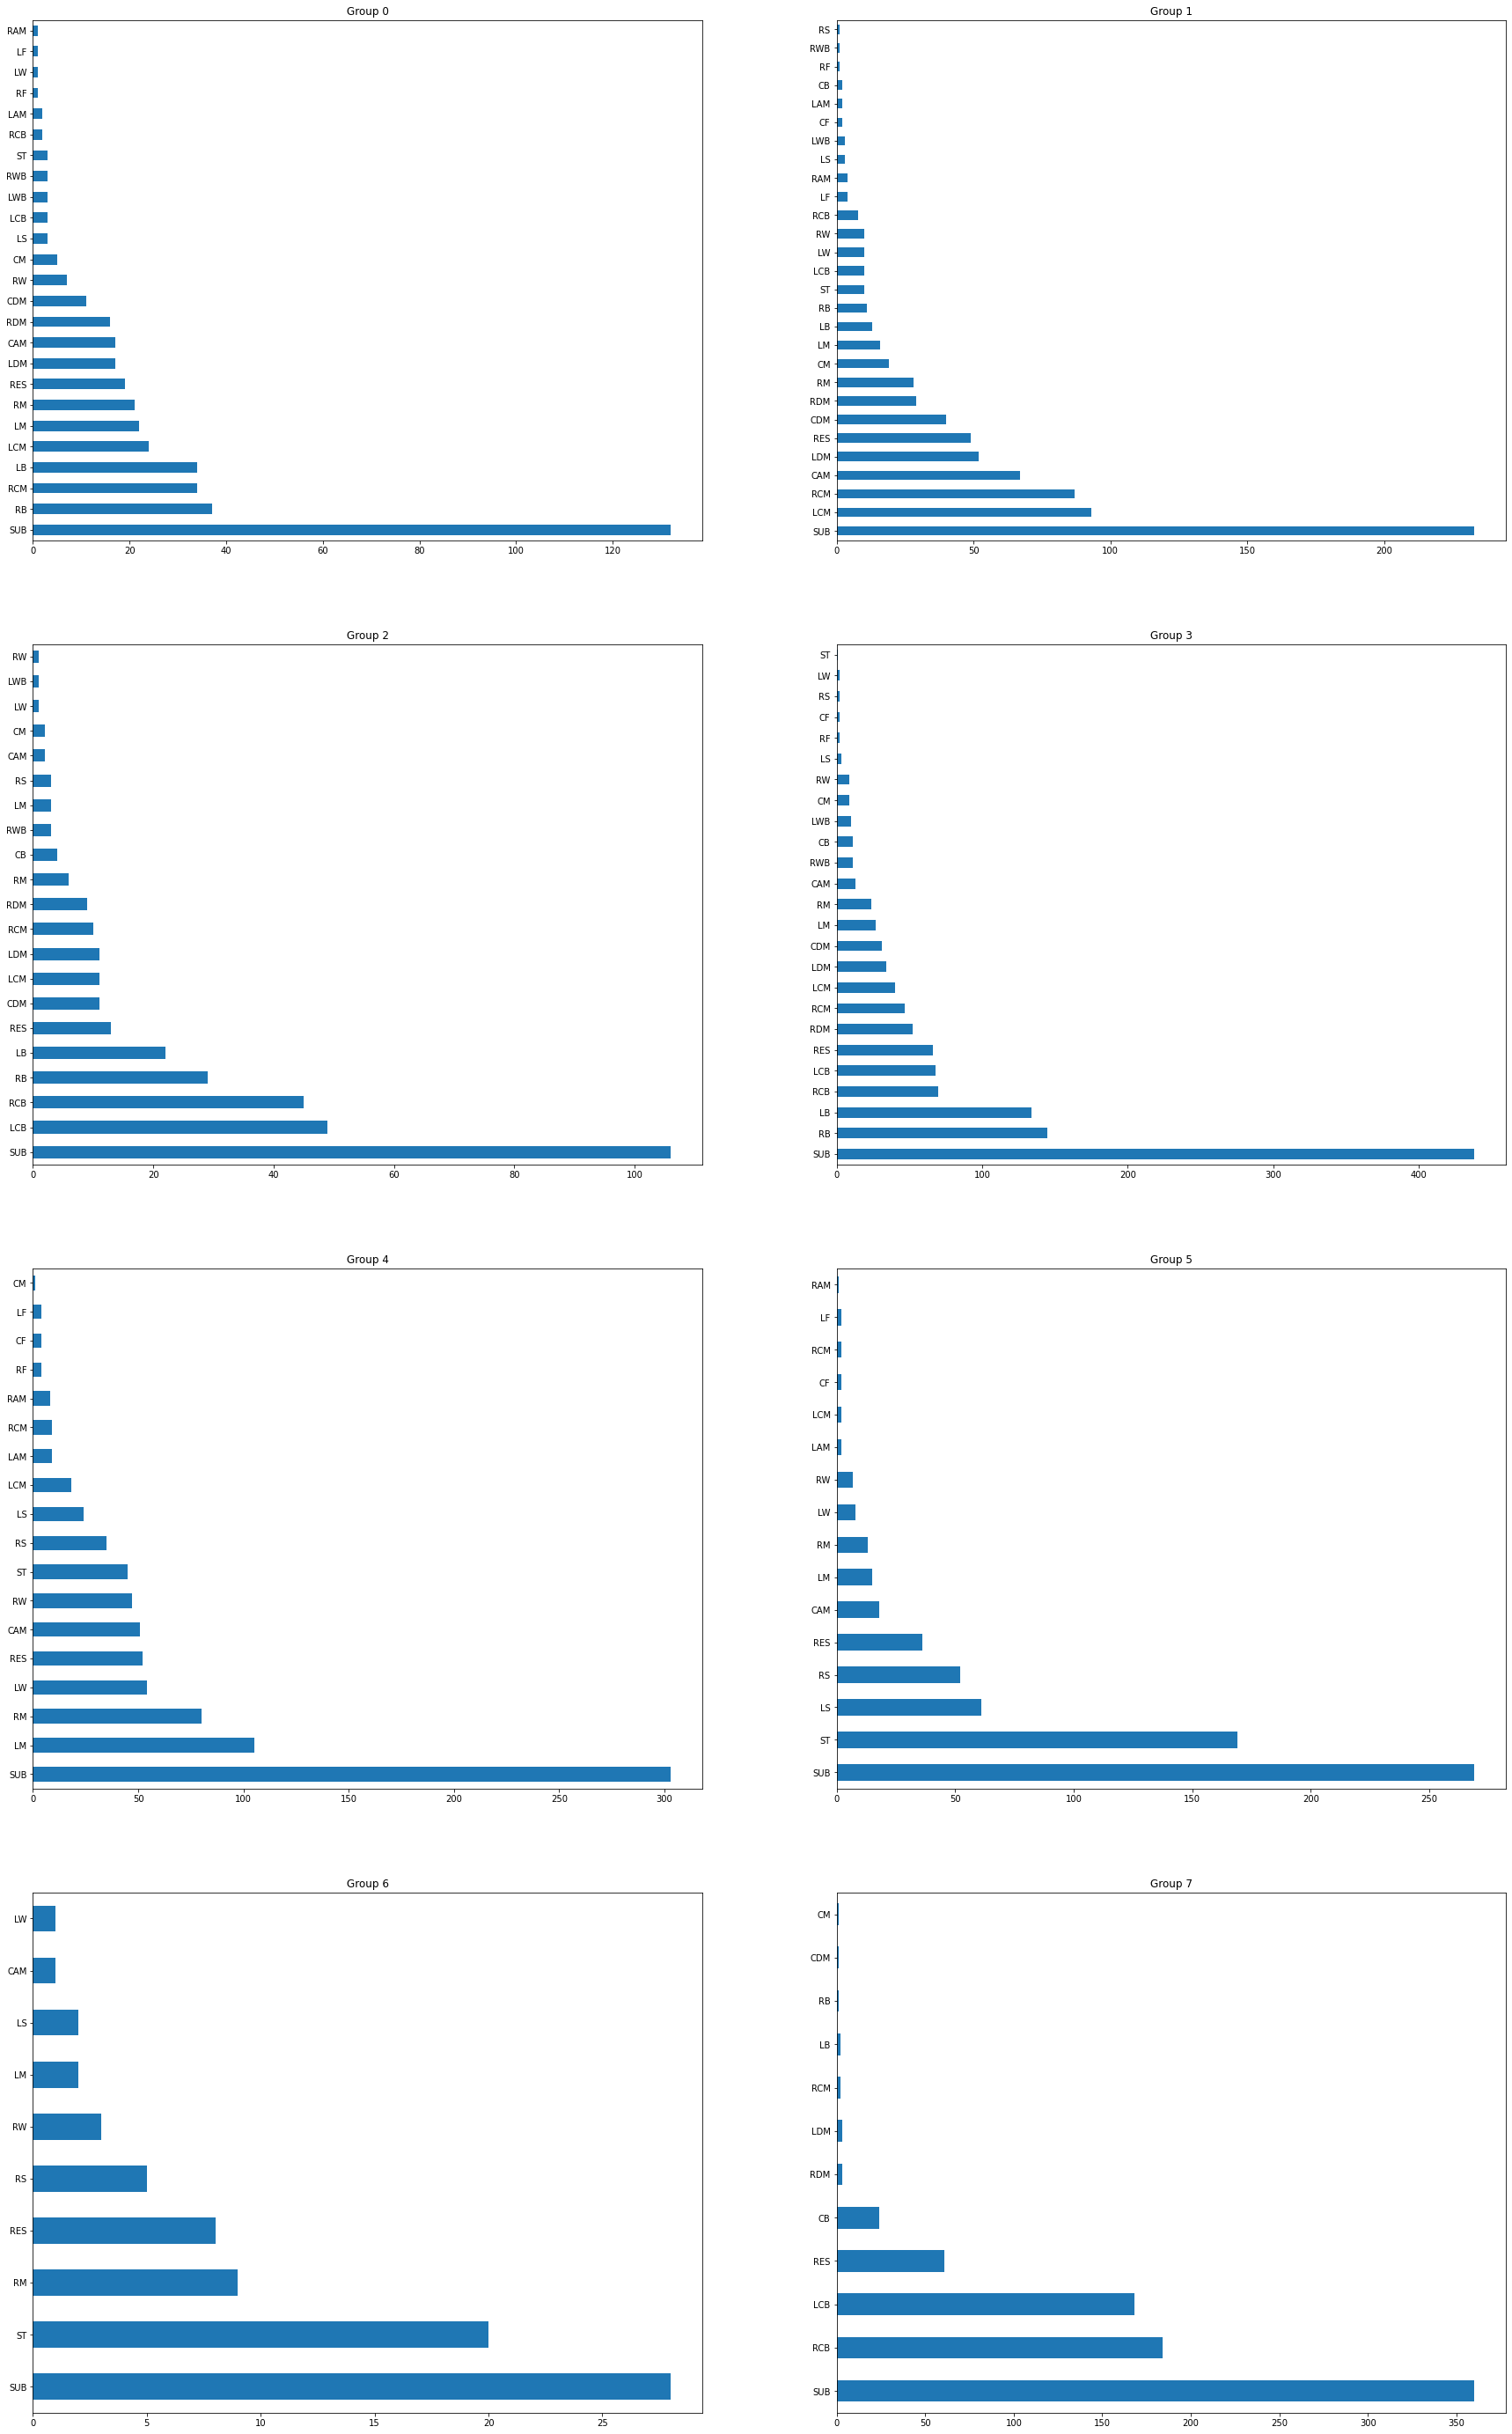

In [41]:
df_meanshift = df_without_GK.copy()
df_meanshift['group_label'] = ms.labels_
column_name = 'team_position'
(fig, axs) = plt.subplots(4, 2, figsize=(30, 50), sharey=False)
get_colum_series_by_group(df_ms_no_GK, column_name,
                          0).value_counts().plot(kind='barh',
        title='Group 0', ax=axs[0][0])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          1).value_counts().plot(kind='barh',
        title='Group 1', ax=axs[0][1])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          2).value_counts().plot(kind='barh',
        title='Group 2', ax=axs[1][0])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          3).value_counts().plot(kind='barh',
        title='Group 3', ax=axs[1][1])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          4).value_counts().plot(kind='barh',
        title='Group 4', ax=axs[2][0])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          5).value_counts().plot(kind='barh',
        title='Group 5', ax=axs[2][1])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          6).value_counts().plot(kind='barh',
        title='Group 6', ax=axs[3][0])
get_colum_series_by_group(df_ms_no_GK, column_name,
                          7).value_counts().plot(kind='barh',
        title='Group 7', ax=axs[3][1])
